# Геометрические фигуры
Найдем объекты простой формы: линии, круги, маски

Изображение: https://video.ittensive.com/machine-vision/barcode.example.png

Маска: https://video.ittensive.com/machine-vision/barcode.mask.png

### Подключение библиотек

In [1]:
%matplotlib inline
import numpy as np
import cv2
import os, os.path
import matplotlib.pyplot as plt

### Выделение контуров
Предварительная фильтрация + Канни

In [2]:
def show_image (image):
    plt.figure(figsize=(16,8))
    plt.imshow(np.uint8(np.absolute(image)))
    plt.show()

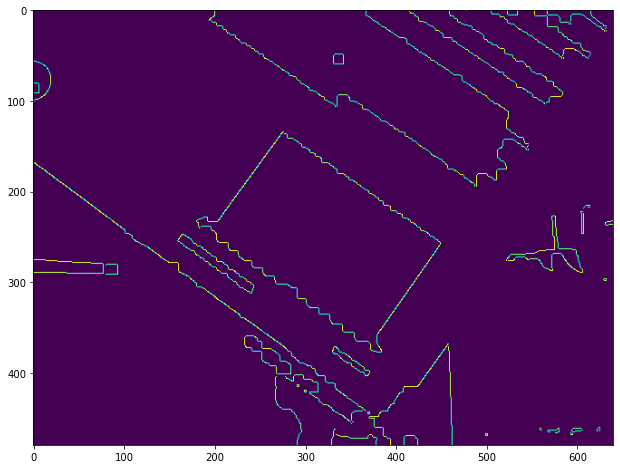

In [3]:
image = cv2.imread("barcode.example.png")
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
otsu, image_thresh = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
image_open = cv2.morphologyEx(image_thresh, cv2.MORPH_OPEN, np.ones((3,3)), iterations = 5)
image_canny = cv2.Canny(image_open, otsu/2, otsu)
show_image(image_canny)

### Преобразования Хафа
Найдем наиболее вероятные линии из границ Канни, не менее 100 точек

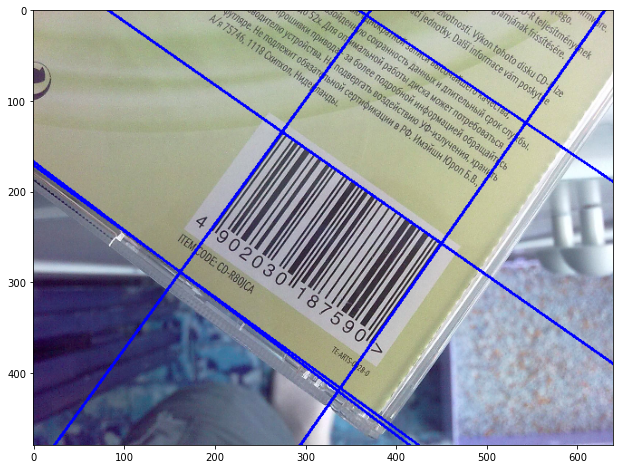

In [4]:
lines = cv2.HoughLines(image_canny, 1, np.pi/180, 100)
img = image.copy()
for line in lines:
    (rho, theta) = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))
    cv2.line(img, (x1,y1), (x2,y2), (0,0,255), 2)
show_image(img)

Найдем окружности поверх Канни через преобразования Хафа

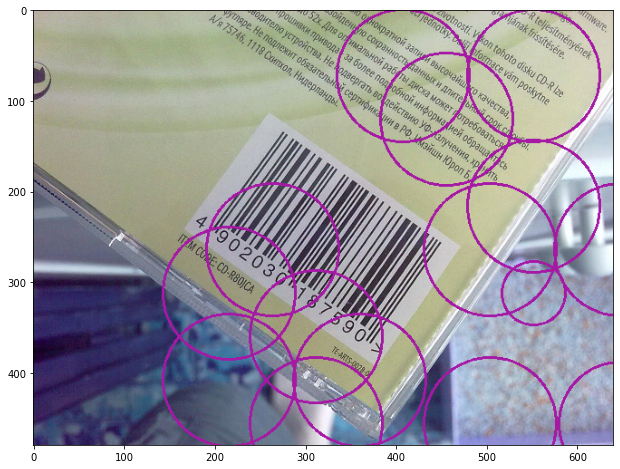

In [5]:
img = image.copy()
circles = cv2.HoughCircles(image_canny, cv2.HOUGH_GRADIENT, image.shape[0]/10, image.shape[0]/10,
                           param1=otsu, param2=otsu/2, minRadius=30, maxRadius=100)
for i in np.uint16(np.around(circles))[0,:]:
    cv2.circle(img, (i[0],i[1]), i[2], (165,25,165), 2)
show_image(img)

Расчет эллипсов по методу наименьших квадратов

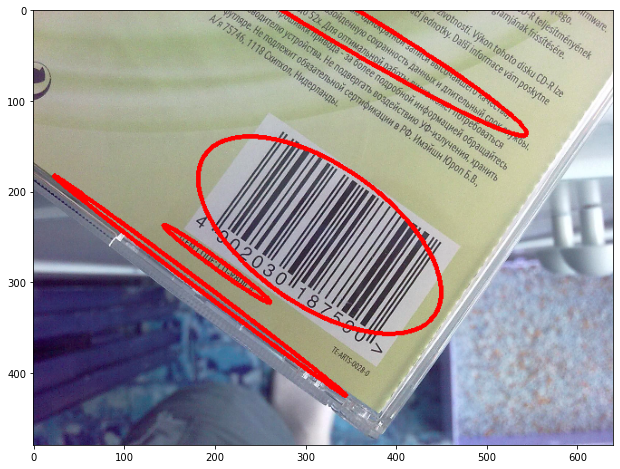

In [6]:
img = image.copy()
contours, _ = cv2.findContours(image_canny, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for contour in contours:
    if contour.shape[0] > image.shape[0]/2:
        ellipse = cv2.fitEllipse(contour)
        cv2.ellipse(img, ellipse, (255, 0, 0), 3)
show_image(img)

### Поиск по маске
Создадим маску из штрихкода, найдем центр ее совпадения на исходном изображении. Режимы:
* TM_SQDIFF, TM_SQDIFF_NORMED - разница пикселей маски и изображения
* TM_CCORR, TM_CCORR_NORMED - корреляция пикселей
* TM_CCOEFF, TM_CCOEFF_NORMED - строгая корреляция пикселей

(217, 204)


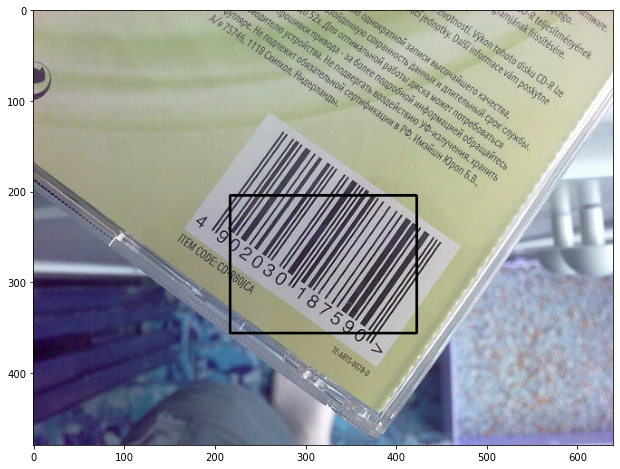

In [7]:
img = image.copy()
image_mask = cv2.cvtColor(cv2.imread("barcode.mask.png"), cv2.COLOR_BGR2GRAY)
result = cv2.matchTemplate(image_gray, image_mask, cv2.TM_CCORR_NORMED)
cv2.normalize(result, result, 0, 1, cv2.NORM_MINMAX, -1)
_minVal, _maxVal, minLoc, maxLoc = cv2.minMaxLoc(result, None)
print (minLoc)
cv2.rectangle(img, minLoc, (minLoc[0] + image_mask.shape[1], minLoc[1] + image_mask.shape[0]), (0,0,0), 2, 8, 0 )
show_image(img)